<a href="https://colab.research.google.com/github/JaeHeee/Tensorflow_practice/blob/master/keras_practice/5.3_pretrained_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top=False, # 최상위 완전 연결 분류기 포함 여부
                  input_shape=(150,150,3))

Using TensorFlow backend.


58892288/58889256 [==============================] - 6s 0us/step


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

데이터 증식 사용하지 않는 빠른 특성 추출

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './drive/My Drive/Colab Notebooks/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [0]:
from tensorflow import keras

In [7]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 6ms/step - loss: 0.5847 - acc: 0.6750 - val_loss: 0.4365 - val_acc: 0.8350
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.4384 - acc: 0.7980 - val_loss: 0.3621 - val_acc: 0.8700
Epoch 3/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3629 - acc: 0.8485 - val_loss: 0.3223 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3175 - acc: 0.8685 - val_loss: 0.2982 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2962 - acc: 0.8810 - val_loss: 0.2859 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2682 - acc: 0.8955 - val_loss: 0.2760 - val_acc: 0.8880
Epoch 7/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2520 - acc: 0.9030 - val_loss: 0.2632 - val_acc: 0.8910
Epoch 8/30
100/100 [==============================] - 0s 5ms/step - loss: 0.

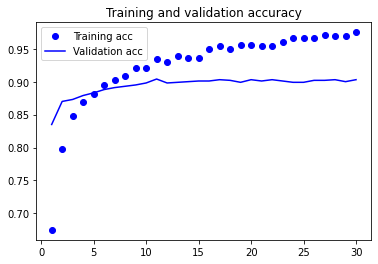

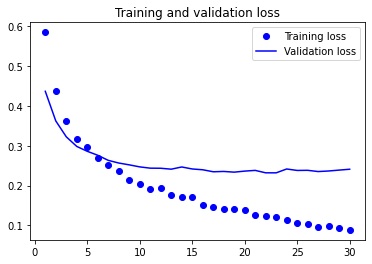

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
import keras

데이터 증식을 사용한 특성 추출

In [0]:
model = keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [0]:
conv_base.trainable = False

In [21]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 23s - loss: 0.5548 - acc: 0.7445 - val_loss: 0.5224 - val_acc: 0.8320
Epoch 2/30
 - 21s - loss: 0.4112 - acc: 0.8375 - val_loss: 0.2516 - val_acc: 0.8730
Epoch 3/30
 - 21s - loss: 0.3548 - acc: 0.8525 - val_loss: 0.2540 - val_acc: 0.8660
Epoch 4/30
 - 21s - loss: 0.3310 - acc: 0.8545 - val_loss: 0.2449 - val_acc: 0.8880
Epoch 5/30
 - 21s - loss: 0.3170 - acc: 0.8695 - val_loss: 0.3237 - val_acc: 0.8930
Epoch 6/30
 - 21s - loss: 0.2968 - acc: 0.8815 - val_loss: 0.3842 - val_acc: 0.8980
Epoch 7/30
 - 21s - loss: 0.2840 - acc: 0.8850 - val_loss: 0.3340 - val_acc: 0.8970
Epoch 8/30
 - 21s - loss: 0.2686 - acc: 0.8925 - val_loss: 0.3262 - val_acc: 0.8890
Epoch 9/30
 - 21s - loss: 0.2592 - acc: 0.8965 - val_loss: 0.1394 - val_acc: 0.8940
Epoch 10/30
 - 21s - loss: 0.2543 - acc: 0.8980 - val_loss: 0.3542 - val_acc: 0.8930
Epoch 11/30
 - 21s - loss: 0.2460 - acc: 0.8965 - val_loss: 0.2540 - val_ac

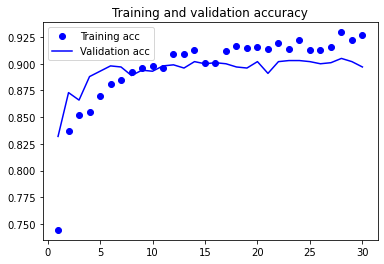

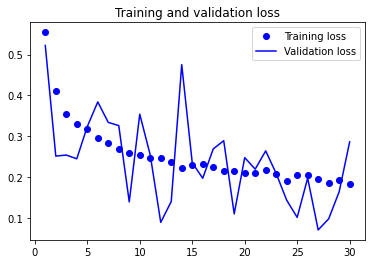

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

fine tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/100
 - 25s - loss: 0.2005 - acc: 0.9190 - val_loss: 0.0524 - val_acc: 0.9170
Epoch 2/100
 - 23s - loss: 0.1619 - acc: 0.9390 - val_loss: 0.4877 - val_acc: 0.9100
Epoch 3/100
 - 23s - loss: 0.1325 - acc: 0.9535 - val_loss: 0.0345 - val_acc: 0.9160
Epoch 4/100
 - 23s - loss: 0.1288 - acc: 0.9515 - val_loss: 0.2756 - val_acc: 0.9190
Epoch 5/100
 - 23s - loss: 0.1061 - acc: 0.9615 - val_loss: 0.2436 - val_acc: 0.9180
Epoch 6/100
 - 23s - loss: 0.0950 - acc: 0.9625 - val_loss: 0.3411 - val_acc: 0.9010
Epoch 7/100
 - 23s - loss: 0.0830 - acc: 0.9685 - val_loss: 0.0364 - val_acc: 0.9210
Epoch 8/100
 - 23s - loss: 0.0710 - acc: 0.9710 - val_loss: 0.1221 - val_acc: 0.9220
Epoch 9/100
 - 24s - loss: 0.0640 - acc: 0.9785 - val_loss: 0.3756 - val_acc: 0.9290
Epoch 10/100
 - 23s - loss: 0.0604 - acc: 0.9770 - val_loss: 0.0295 - val_acc: 0.9210
Epoch 11/100
 - 23s - loss: 0.0586 - acc: 0.9820 - val_loss: 0.4818 - val_acc: 0.9050
Epoch 12/100
 - 23s - loss: 0.0452 - acc: 0.9850 - val_loss: 0.

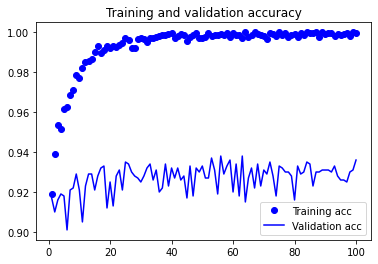

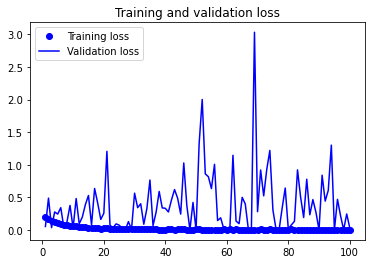

In [26]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

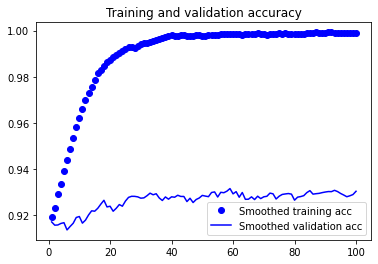

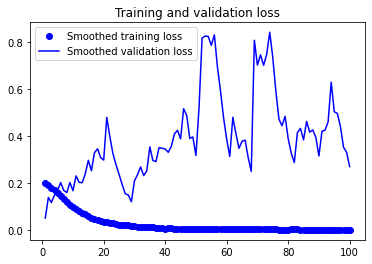

In [27]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9350000023841858
